In [5]:
import pandas as pd

file1 = 'duration.csv'
file2 = 'page_views.csv'
file3 = 'users.csv'


In [6]:
data1 = pd.read_csv(file1, delimiter=',', skiprows=range(0, 6))
data2 = pd.read_csv(file2, delimiter=',', skiprows=range(0, 6))
data3 = pd.read_csv(file3, delimiter=',', skiprows=range(0, 6))

data1.head(), data2.head(), data3.head()


(  Індекс дня Сер. тривалість сеансу
 0   01.03.23               00:02:55
 1   02.03.23               00:03:36
 2   03.03.23               00:03:25
 3   04.03.23               00:03:02
 4   05.03.23               00:02:53,
   Індекс дня Перегляди сторінок
 0   01.03.23              9 257
 1   02.03.23             10 602
 2   03.03.23              9 541
 3   04.03.23              6 087
 4   05.03.23              5 472,
   Індекс дня Користувачі
 0   01.03.23       2 132
 1   02.03.23       2 117
 2   03.03.23       2 005
 3   04.03.23       1 361
 4   05.03.23       1 301)

In [15]:
# Функція для конвертації тривалості сесії у секунди
def duration_to_seconds(duration):
    if isinstance(duration, str):
        h, m, s = map(int, duration.split(':'))
        return h * 3600 + m * 60 + s
    return duration

# Підготовка даних для Prophet
def prepare_data(data, date_col, value_col, is_duration=False):
    data[date_col] = pd.to_datetime(data[date_col], format='%d.%m.%y', errors='coerce')
    if is_duration:
        data[value_col] = data[value_col].apply(duration_to_seconds)
    else:
        data[value_col] = pd.to_numeric(data[value_col].astype(str).str.replace('\xa0', '').str.replace(',', ''), errors='coerce')
    data = data.rename(columns={date_col: 'ds', value_col: 'y'})
    data = data.dropna(subset=['ds', 'y'])  # Видалення рядків з NaN
    return data

# Вибір метрик
duration_data = prepare_data(data1, 'Індекс дня', 'Сер. тривалість сеансу', is_duration=True)
pageviews_data = prepare_data(data2, 'Індекс дня', 'Перегляди сторінок')
users_data = prepare_data(data3, 'Індекс дня', 'Користувачі')

# Відображення підготовлених даних
duration_data.head(), pageviews_data.head(), users_data.head()

(          ds    y
 0 2023-03-01  175
 1 2023-03-02  216
 2 2023-03-03  205
 3 2023-03-04  182
 4 2023-03-05  173,
           ds        y
 0 2023-03-01   9257.0
 1 2023-03-02  10602.0
 2 2023-03-03   9541.0
 3 2023-03-04   6087.0
 4 2023-03-05   5472.0,
           ds       y
 0 2023-03-01  2132.0
 1 2023-03-02  2117.0
 2 2023-03-03  2005.0
 3 2023-03-04  1361.0
 4 2023-03-05  1301.0)

In [10]:
!pip install prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbym2f82b/okl_u27z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbym2f82b/3e6brohc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88089', 'data', 'file=/tmp/tmpbym2f82b/okl_u27z.json', 'init=/tmp/tmpbym2f82b/3e6brohc.json', 'output', 'file=/tmp/tmpbym2f82b/prophet_modelmar2xedr/prophet_model-20240527144014.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:40:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonali

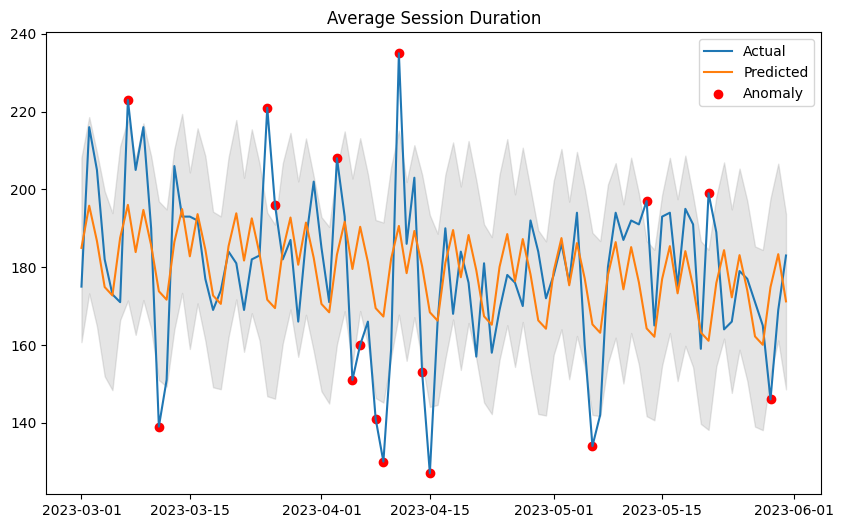

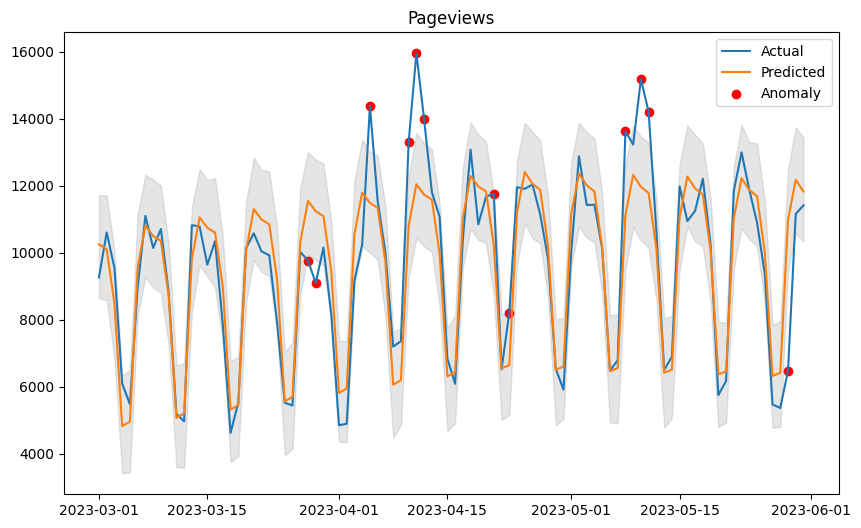

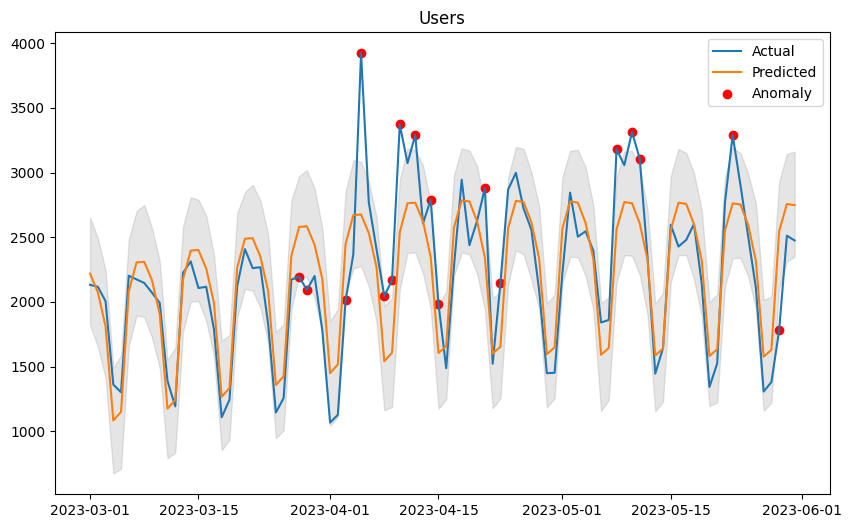

In [16]:
# Функція для визначення аномалій з використанням Prophet
def detect_anomalies(data):
    model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    data['yhat'] = forecast['yhat'].iloc[:len(data)]
    data['yhat_upper'] = forecast['yhat_upper'].iloc[:len(data)]
    data['yhat_lower'] = forecast['yhat_lower'].iloc[:len(data)]
    data['anomaly'] = data.apply(lambda row: row['y'] > row['yhat_upper'] or row['y'] < row['yhat_lower'], axis=1)
    return data

# Визначення аномалій
duration_anomalies = detect_anomalies(duration_data)
pageviews_anomalies = detect_anomalies(pageviews_data)
users_anomalies = detect_anomalies(users_data)

# Візуалізація аномалій
def plot_anomalies(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data['ds'], data['y'], label='Actual')
    plt.plot(data['ds'], data['yhat'], label='Predicted')
    plt.fill_between(data['ds'], data['yhat_lower'], data['yhat_upper'], color='gray', alpha=0.2)
    plt.scatter(data[data['anomaly']]['ds'], data[data['anomaly']]['y'], color='red', label='Anomaly')
    plt.title(title)
    plt.legend()
    plt.show()

# Відображення графіків з аномаліями
plot_anomalies(duration_anomalies, 'Average Session Duration')
plot_anomalies(pageviews_anomalies, 'Pageviews')
plot_anomalies(users_anomalies, 'Users')

In [17]:
import numpy as np
from scipy import stats
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

In [46]:
def detect_anomalies_zscore(data, threshold=3):
    data['z_score'] = stats.zscore(data['y'])
    data['anomaly'] = data['z_score'].abs() > threshold
    return data

# Function for Isolation Forest method
def detect_anomalies_isolation_forest(data):
    model = IsolationForest(contamination=0.01, random_state=42)
    data['anomaly'] = model.fit_predict(data[['y']].values.reshape(-1, 1))
    data['anomaly'] = data['anomaly'] == -1  # -1 indicates anomaly
    return data

# Function for Moving Average method with adjustable window and threshold
def detect_anomalies_moving_average(data, window=5, threshold=2):
    data['moving_avg'] = data['y'].rolling(window=window).mean()
    data['moving_std'] = data['y'].rolling(window=window).std()
    data['anomaly'] = (data['y'] - data['moving_avg']).abs() > (threshold * data['moving_std'])

    # Debugging: Print some of the calculations
    print(data[['ds', 'y', 'moving_avg', 'moving_std', 'anomaly']].head(20))
    return data


# Function for IQR method
def detect_anomalies_iqr(data):
    Q1 = data['y'].quantile(0.25)
    Q3 = data['y'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data['anomaly'] = (data['y'] < lower_bound) | (data['y'] > upper_bound)
    return data

In [23]:
# Visualization function
def plot_anomalies(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data['ds'], data['y'], label='Actual')
    plt.scatter(data[data['anomaly']]['ds'], data[data['anomaly']]['y'], color='red', label='Anomaly', s=50)
    plt.title(title)
    plt.legend()
    plt.show()

In [32]:
# Check the Z-scores
duration_anomalies_z = detect_anomalies_zscore(duration_data.copy())
print(duration_anomalies_z[['ds', 'y', 'z_score', 'anomaly']].head(10))

          ds    y   z_score  anomaly
0 2023-03-01  175 -0.199138    False
1 2023-03-02  216  1.830990    False
2 2023-03-03  205  1.286322    False
3 2023-03-04  182  0.147470    False
4 2023-03-05  173 -0.298168    False
5 2023-03-06  171 -0.397199    False
6 2023-03-07  223  2.177598    False
7 2023-03-08  205  1.286322    False
8 2023-03-09  216  1.830990    False
9 2023-03-10  190  0.543592    False


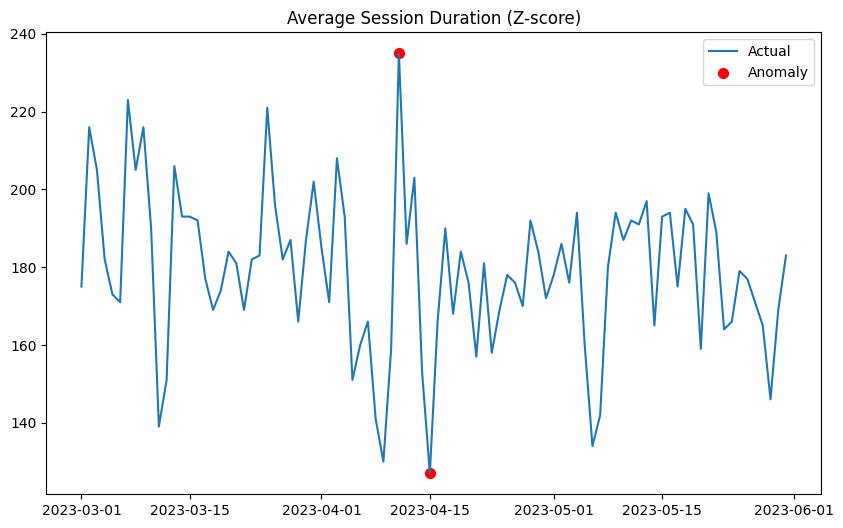

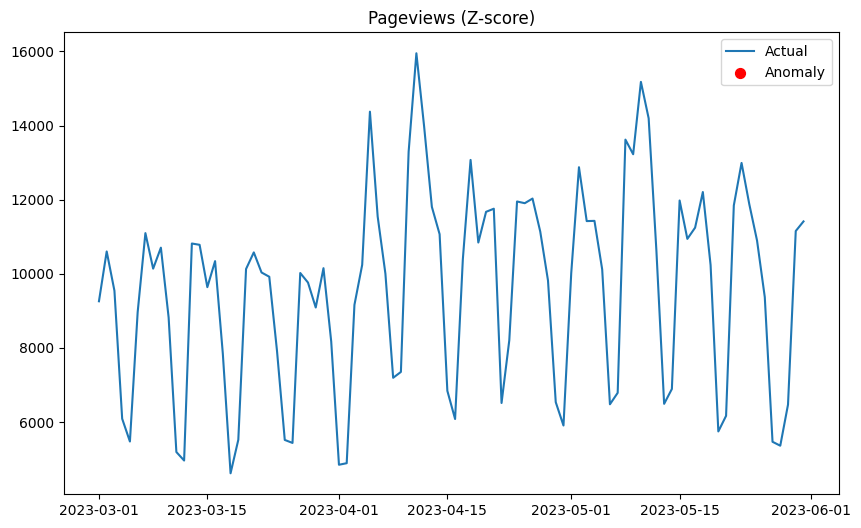

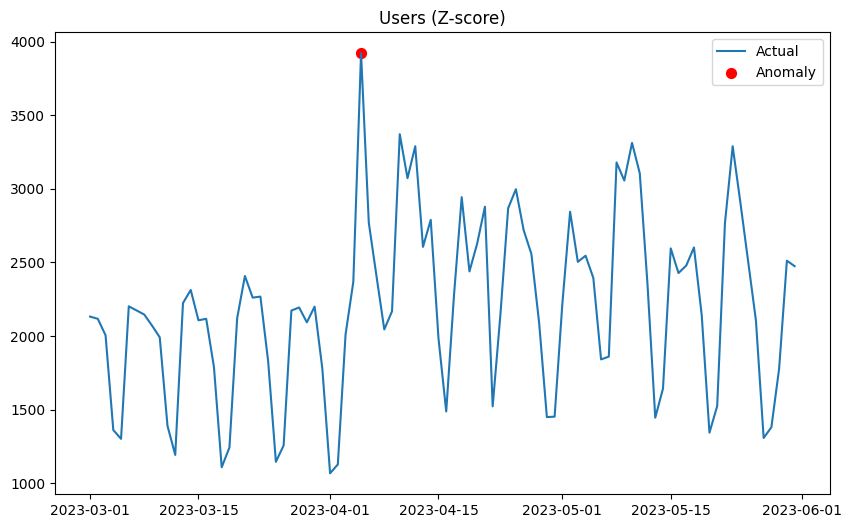

In [39]:
duration_anomalies_z = detect_anomalies_zscore(duration_data.copy(), threshold=2.5)
pageviews_anomalies_z = detect_anomalies_zscore(pageviews_data.copy(), threshold=2.5)
users_anomalies_z = detect_anomalies_zscore(users_data.copy(), threshold=2.5)

plot_anomalies(duration_anomalies_z, 'Average Session Duration (Z-score)')
plot_anomalies(pageviews_anomalies_z, 'Pageviews (Z-score)')
plot_anomalies(users_anomalies_z, 'Users (Z-score)')


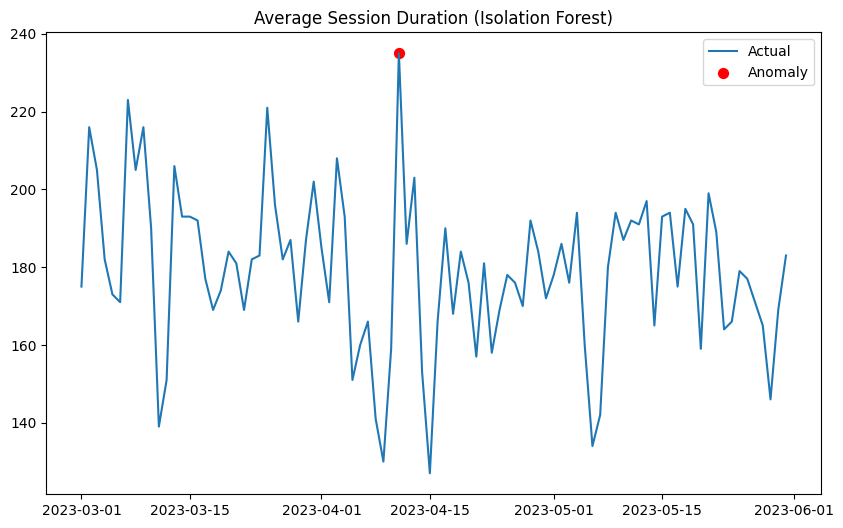

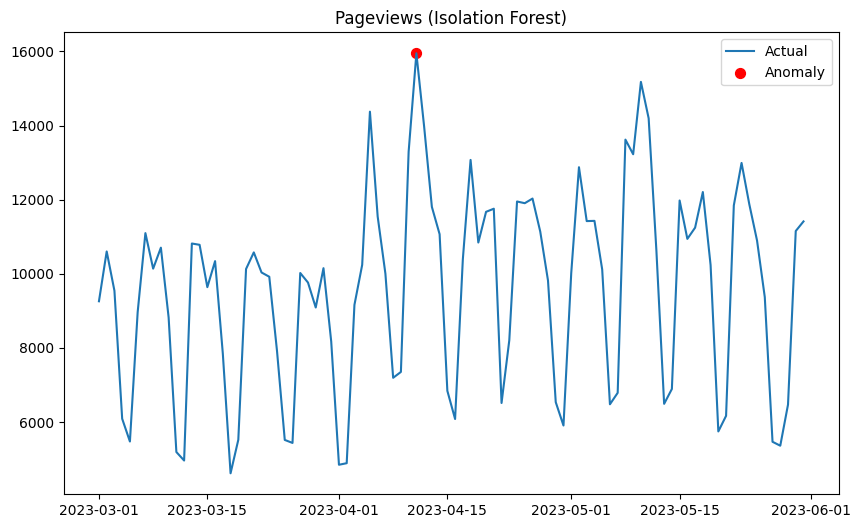

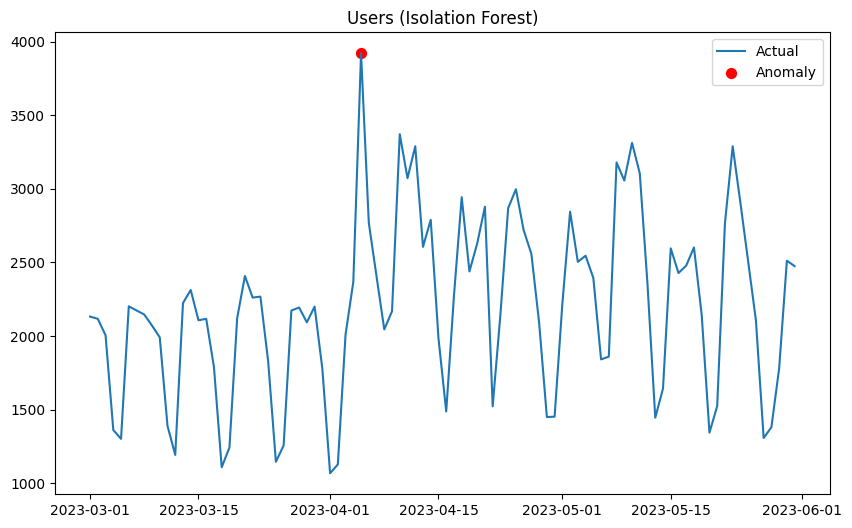

In [43]:
# Isolation Forest method
duration_anomalies_if = detect_anomalies_isolation_forest(duration_data.copy())
pageviews_anomalies_if = detect_anomalies_isolation_forest(pageviews_data.copy())
users_anomalies_if = detect_anomalies_isolation_forest(users_data.copy())

plot_anomalies(duration_anomalies_if, 'Average Session Duration (Isolation Forest)')
plot_anomalies(pageviews_anomalies_if, 'Pageviews (Isolation Forest)')
plot_anomalies(users_anomalies_if, 'Users (Isolation Forest)')


           ds    y  moving_avg  moving_std  anomaly
0  2023-03-01  175         NaN         NaN    False
1  2023-03-02  216         NaN         NaN    False
2  2023-03-03  205         NaN         NaN    False
3  2023-03-04  182         NaN         NaN    False
4  2023-03-05  173       190.2   19.227584    False
5  2023-03-06  171       189.4   20.082331    False
6  2023-03-07  223       190.8   22.498889    False
7  2023-03-08  205       190.8   22.498889    False
8  2023-03-09  216       197.6   24.244587    False
9  2023-03-10  190       201.0   20.892582    False
10 2023-03-11  139       194.6   33.485818    False
11 2023-03-12  151       180.2   33.700148    False
12 2023-03-13  206       180.4   33.886576    False
13 2023-03-14  193       175.8   29.063723    False
14 2023-03-15  193       176.4   29.458445    False
15 2023-03-16  192       187.0   20.940392    False
16 2023-03-17  177       192.2   10.281051    False
17 2023-03-18  169       184.8   11.144505    False
18 2023-03-1

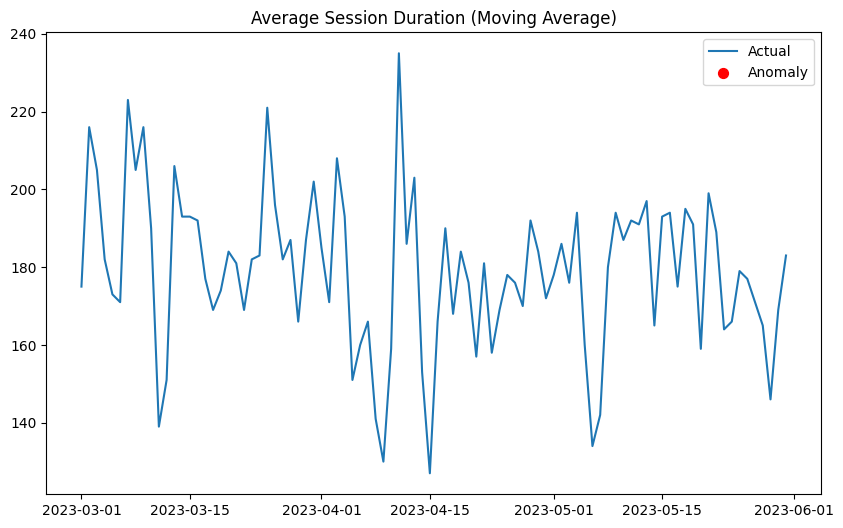

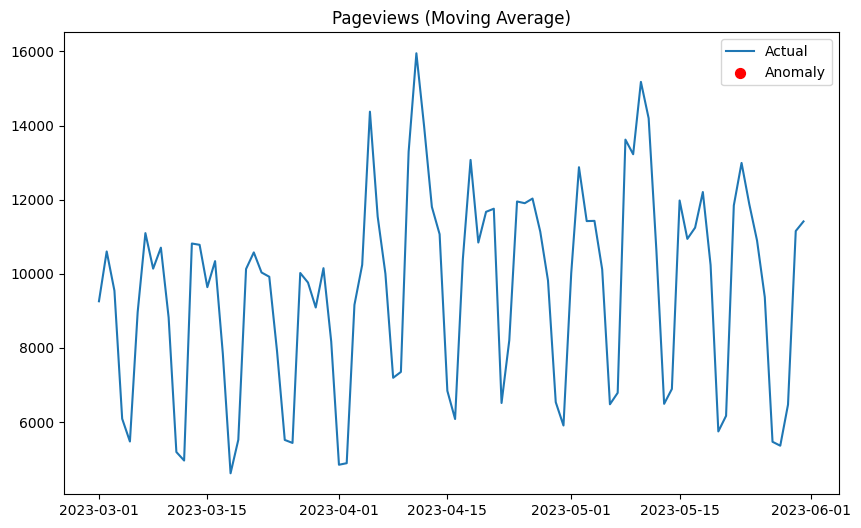

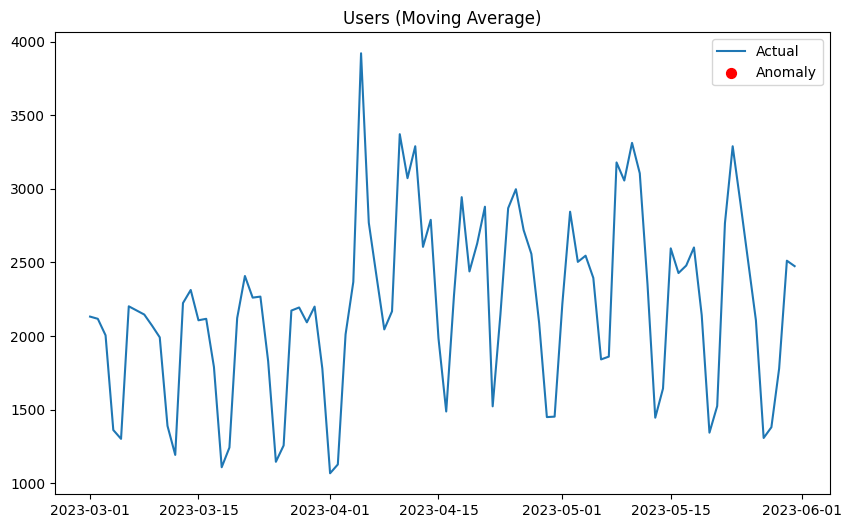

In [47]:

# Moving Average method with different parameters
duration_anomalies_ma = detect_anomalies_moving_average(duration_data.copy(), window=5, threshold=2)
pageviews_anomalies_ma = detect_anomalies_moving_average(pageviews_data.copy(), window=5, threshold=2)
users_anomalies_ma = detect_anomalies_moving_average(users_data.copy(), window=5, threshold=2)

plot_anomalies(duration_anomalies_ma, 'Average Session Duration (Moving Average)')
plot_anomalies(pageviews_anomalies_ma, 'Pageviews (Moving Average)')
plot_anomalies(users_anomalies_ma, 'Users (Moving Average)')


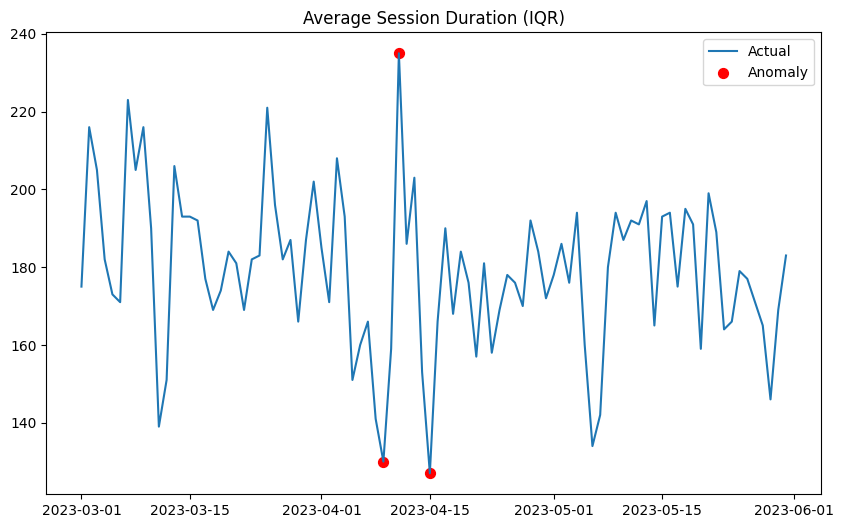

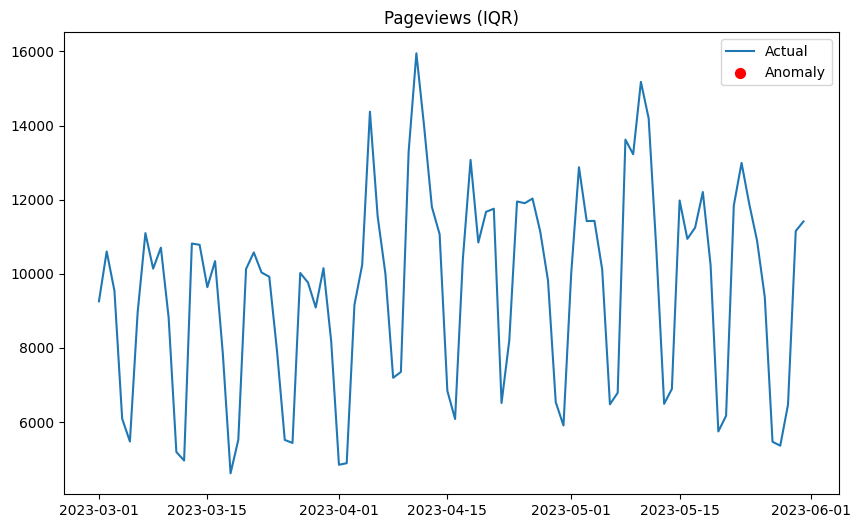

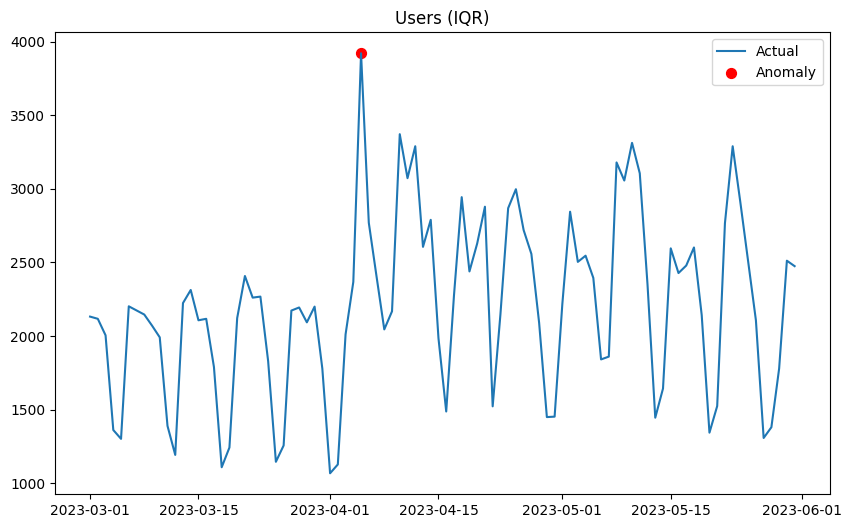

In [27]:
# IQR method
duration_anomalies_iqr = detect_anomalies_iqr(duration_data.copy())
pageviews_anomalies_iqr = detect_anomalies_iqr(pageviews_data.copy())
users_anomalies_iqr = detect_anomalies_iqr(users_data.copy())

plot_anomalies(duration_anomalies_iqr, 'Average Session Duration (IQR)')
plot_anomalies(pageviews_anomalies_iqr, 'Pageviews (IQR)')
plot_anomalies(users_anomalies_iqr, 'Users (IQR)')